In [2]:
!pip install scikit-learn

     |████████████████████████████████| 22.2 MB 498 kB/s eta 0:00:01


In [4]:
import numpy as np
import sys
import glob
from collections import defaultdict
import os
sys.path.append("/home/eltayeb/phyre_proj/codebase/phyre_agents/agents")

import phyre
from torch import nn
import torch
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

from visualize_policy import visualize_policy
import visualize_policy as vp
from neural_agent import build_model, get_latest_checkpoint, eval_actions, load_agent_from_folder
from nets import ResNetFilmAction
from psim import ParallelPhyreSimulator
#from min_dists import batched_min_dist

import weakref


In [5]:
sns.set_style("whitegrid")
import os.path as osp
def save_graph(fig, outfpath):
    # Any postprocessing of the graphs
    sns.despine(top=True, right=True, left=False, bottom=False)
    # Save code
    paper_outfpath = outfpath #osp.join(PAPER_DIR, outfpath)
    #os.makedirs(osp.dirname(paper_outfpath), exist_ok=True)
    fig.savefig(paper_outfpath,
                bbox_inches='tight',
                transparent=True,
                pad_inches=0)

In [6]:
data = np.genfromtxt("dists.csv", delimiter=",")
data = data[:, [0, 1, 2]]
columns = ["task", "ours", "baseline"]

OSError: dists.csv not found.

In [33]:
(data[:, 1] - data[:, 2]).max()

0.08499999999999996

In [10]:
def get_per_template_results(glob_path):
    dirs =  glob.glob(glob_path)
    results = defaultdict(lambda:[]) 
    counts = defaultdict(lambda: 0)
    for dir_ in dirs:
        files = os.listdir(dir_)
        name = "detail_report.csv" 
        if name not in files:
            name = "detailed_results.csv"
        assert (name in files)
        with open(os.path.join(dir_, name),"r") as file_io:
            report = file_io.read()
        for line in report.split():
            line = line.split(",")
            if len(line) == 2:
                results[line[0]].append(float(line[1]))
                counts[line[0]] += 1

    results = sorted(tuple(results.items()))
    results = np.array([entry[1] for entry in results])
    return results

ours = get_per_template_results("/home/eltayeb/phyre_proj/dev/results/dynamics_aware_dqn/exp18/comb_outer/seed_*")
baseline = get_per_template_results("/home/eltayeb/phyre_proj/misc/exp2/ball_within_template/aux_loss_0/seed_*")

In [11]:
ours.mean(), baseline.mean()

(0.8335000000000001, 0.8175999999999999)

In [12]:
template_ids = phyre.get_fold("ball_within_template", 0)[0]
templates = {}

for template_id in template_ids:
    templates[template_id.split(":")[0]] = template_id

task_ids = sorted(list(templates.values()))
print(task_ids)
one_per_template_sim = phyre.initialize_simulator(task_ids, "ball")
cache_data = phyre.get_default_100k_cache("ball").get_sample(task_ids)

['00000:099', '00001:099', '00002:199', '00003:111', '00004:978', '00005:197', '00006:198', '00007:357', '00008:619', '00009:996', '00010:534', '00011:977', '00012:228', '00013:291', '00014:636', '00015:496', '00016:895', '00017:198', '00018:197', '00019:998', '00020:099', '00021:125', '00022:997', '00023:990', '00024:693']


In [13]:
def get_valid_action(ind, cache_data):
    valid_action_inds = cache_data["simulation_statuses"][ind, :1000] != 0
    return cache_data["actions"][valid_action_inds.argmax()]

In [14]:
num_moving_objects = {}
jars = {}

for ind, _ in enumerate(task_ids):
    
    valid_action = get_valid_action(ind, cache_data)
    results = one_per_template_sim.simulate_action(ind, valid_action, need_images=False, need_featurized_objects=True)
    colors = results.featurized_objects.colors
    shapes = results.featurized_objects.shapes
    num_moving_objects[ind] = colors.count("RED") + colors.count("GREEN") + colors.count("GRAY") + colors.count("BLUE")
    jars[ind] = int("JAR" in shapes)
    
moving_object_arr = sorted(num_moving_objects.items())
moving_object_arr = np.array([x[1] for x in moving_object_arr])


jar_arr = sorted(jars.items())
jar_arr = np.array([x[1] for x in jar_arr])

/home/eltayeb/anaconda3/envs/cluster/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(25,)


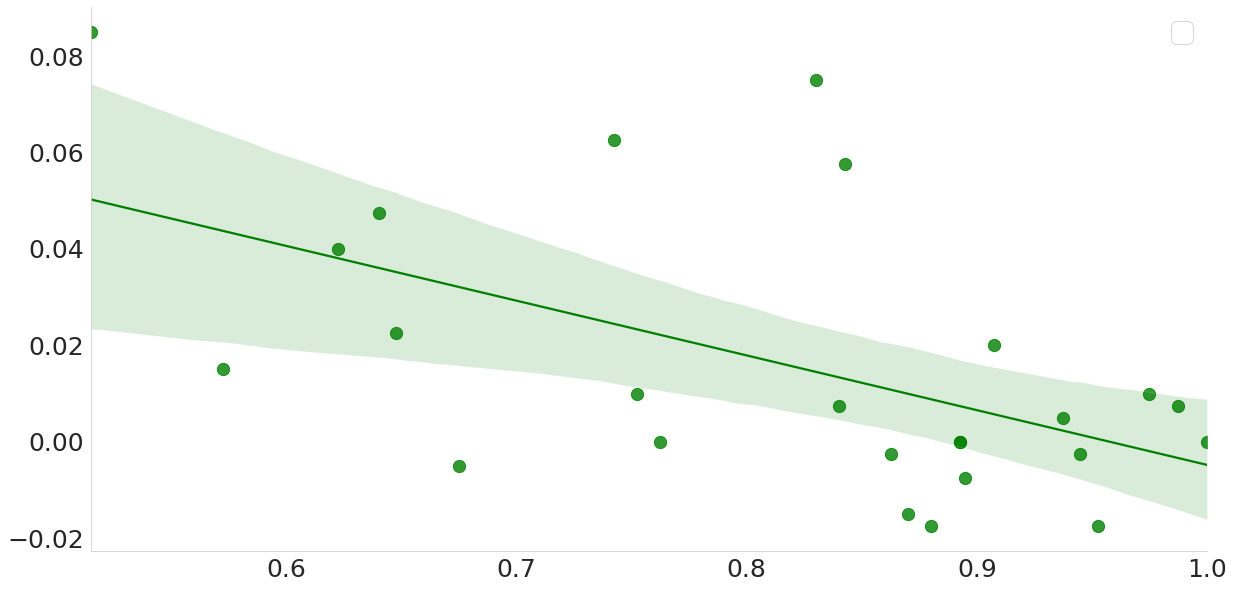

In [15]:
i = 0
plt.figure(figsize=(20, 10))

#params = ["Baseline", "Moving Objects", "Jars"]
#values = [ baseline.mean(axis=1), moving_object_arr, jar_arr]

params = ["Baseline"]
values = [ baseline.mean(axis=1)]
diffs = (ours - baseline).mean(axis=1)

for title, values in zip(params, values):
    i += 1
    plt.subplot(1,len(params),i)
 #   plt.ylabel("#" + title)
  #  plt.ylabel("$\Delta$ Auccess")
    

    sns.regplot(values, diffs.ravel(), scatter_kws={"s":50 * 3 }, color="green")
    x_lim = plt.xlim()
    #plt.hlines([0], *x_lim)

    print(values.shape)

fontsize = 25
#plt.xlabel("Baseline AUCCESS", fontsize=fontsize)
#plt.ylabel("$\Delta$ AUCCESS", fontsize=fontsize)
plt.legend(prop={'size': 28}, loc='upper right')#, bbox_to_anchor=(0.6, 1))
plt.grid(axis="y")
plt.grid(axis="x")

ax = plt.gca()
ax.set_axisbelow(True)

tick_fontsize = 25
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 
#     tick.set_url(f'https://player.phyre.ai/#/task/:')  # Not working
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 

tick_fontsize = 25

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 
#     tick.set_url(f'https://player.phyre.ai/#/task/:')  # Not working
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 
#plt.savefig("meanOverSeedRegPlot.png")
save_graph(plt.gcf(), "meanOverSeedRegPlot.pdf")


In [16]:
import scipy.stats

diffs = (ours - baseline)
print(scipy.stats.pearsonr(diffs.ravel(), baseline.ravel()))
print(scipy.stats.pearsonr(diffs.mean(axis=1), baseline.mean(axis=1)))

(-0.41570649698775164, 1.6992662741386638e-05)
(-0.5410068125032882, 0.005229561983884762)


In [17]:
COL = sns.color_palette().as_hex()[:5]


MARKER = ['o', '^']
COL_BLK = 'k'
COL_GREY = '#A9A9A9'
# Formatting for different models
FMT_IN = (COL[0], MARKER[0], '-')
FMT_IN_TXCLS = (COL[0], MARKER[0], '-.')
FMT_TX = (COL[1], MARKER[0], '-')
FMT_TX_TXCLS = (COL[1], MARKER[0], '-.')
FMT_STN = (COL[-1], MARKER[1], '-')
FMT_STN_CC3D = (COL[-1], MARKER[1], '-.')
FMT_DEC = (COL[-2], MARKER[1], '-')
FMT_DEC_CC3D = (COL[-2], MARKER[1], '-.')
FMT_DECJ = (COL[-3], MARKER[1], '-')
# Upper bounds
FMT_UPPER_OPT = (COL_GREY, ',', '--')
FMT_UPPER_OBJ = (COL[0], MARKER[0], '--')
FMT_UPPER_PIX = (COL[3], MARKER[1], '--')

# Config files for the final results

CFG_WIN_GT_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/029-GT-Tx-in-class-hist1-10-v2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/031-GT-Tx-in-class-hist13.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/031-GT-Tx-in-class-hist13-nonconverged.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/029-GT-Tx-in-class-hist1-10-v2-nonconverged.txt']
CFG_WIN_GT_3F_C3D = 'expts_neurips20/060_GTSim_conv3d_allFold_wTemp_4gpu_ConvConv3D.txt'
CFG_X_GT_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/030-GT-Tx-x-class-hist1-10.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13-nonconverged2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13-nonconverged3.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/030-GT-Tx-x-class-hist1-10-nonconverged2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/030-GT-Tx-x-class-hist1-10-nonconverged1.txt']
CFG_X_GT_3F_C3D = ['expts_neurips20/049_GTSim_conv3d_allFold_xTemp_2gpu.txt', 'expts_neurips20/049_GTSim_conv3d_allFold_xTemp_4gpu_remaining.txt']

CFG_WIN_IN_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/006-cls-IN-win-template-final.txt/'
CFG_WIN_IN_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/037-Txcls-INfwd-withintemplate-4gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/038-Txcls-INfwd-withintemplate-8gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/041-Txcls-INfwd-withintemplate-4gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/043-Txcls-INfwd-withintemplate-8gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/049-Txcls-INfwd-withintemplate-8gpu-fwd7.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/051-Txcls-INfwd-withintemplate-8gpu-learnfair-fwd7.txt']
CFG_WIN_IN_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/000-fwd-IN-win-template-final.txt:0-9'
CFG_X_IN_3F = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/025-cls-IN-cross-template-final-fold1.txt/', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/007-cls-IN-cross-template-final-allfolds-except1.txt/']
CFG_X_IN_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/001-fwd-IN-cross-template-final.txt:0-9'

CFG_WIN_TX_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/023-cls-Tx-win-template-final.txt/'
CFG_WIN_TX_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/039-Txcls-Txfwd-withintemplate-4gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/040-Txcls-Txfwd-withintemplate-8gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/042-Txcls-Txfwd-withintemplate-4gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/044-Txcls-Txfwd-withintemplate-8gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/050-Txcls-Txfwd-withintemplate-8gpu-fwd7.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/052-Txcls-Txfwd-withintemplate-8gpu-learnfair-fwd7.txt']
CFG_WIN_TX_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/018-fwd-Tx-win-template-residual-updated.txt:0-9'
CFG_X_TX_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/024-cls-Tx-cross-template-final.txt/'
CFG_X_TX_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/019-fwd-Tx-cross-template-residual-updated.txt:0-9'

CFG_WIN_STN_3F = ['expts_neurips20/053_STN_cls_wtemp_from_2obInitModel_allfold_2gpu.txt', 'expts_neurips20/053_STN_cls_wtemp_from_2obInitModel_allfold_4gpu_remaining.txt']
CFG_WIN_STN_3F_CONVCONV3D = 'expts_neurips20/058_STN_cls_wtemp_from_2obInitModel_allfold_8gpu_ConvConv3D.txt'
CFG_WIN_STN_3F_ROLLOUT = 'expts_neurips20/046_STNFwd_TempAll_spatXLoss_ResNet_60str_2obj_100Kiter_lowLR_allFold.txt:0-9'
CFG_X_STN_3F = ['expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_2gpu.txt', 'expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_4gpu_remaining.txt', 'expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_4gpu_remaining_fold7.txt']
CFG_X_STN_3F_ROLLOUT = 'expts_neurips20/047_STNFwd_TempAllX_spatXLoss_ResNet_60str_2obj_100Kiter_lowLR_allFold.txt:0-9'

CFG_WIN_DEC_3F = ['expts_neurips20/050_Decoder_noautoenc_10fold_2gpu.txt', 'expts_neurips20/050_Decoder_noautoenc_10fold_2gpu_remaining.txt']
CFG_WIN_DEC_3F_CONVCONV3D = 'expts_neurips20/059_Decoder_noautoenc_10fold_4gpu_ConvConv3D.txt'
CFG_WIN_DEC_3F_ROLLOUT = 'expts/358_DecoderBasedFwd_TempAllW_stride60_wtdLoss_noAutoenc_noReluLast_allFold.txt:0-9'
CFG_X_DEC_3F = ['expts_neurips20/051_Decoder_noautoenc_10fold_xtemp_2gpu.txt', 'expts_neurips20/051_Decoder_noautoenc_10fold_xtemp_2gpu_remaining.txt']
CFG_X_DEC_3F_ROLLOUT = 'expts/357_DecoderBasedFwd_TempAllX_stride60_wtdLoss_noAutoenc_noReluLast_allFold.txt:0-9'

CFG_WIN_DECJ_3F = 'expts_neurips20/045_DecoderJoint_trainFwd5Only_noReluLast_allFold.txt'
CFG_WIN_DECJ_3F_ROLLOUT = 'expts_neurips20/045_DecoderJoint_trainFwd5Only_noReluLast_allFold.txt:70-79'
CFG_X_DECJ_3F = 'expts_neurips20/044_DecoderJoint_xTemp_trainFwd5Only_noReluLast_allFold.txt'
CFG_X_DECJ_3F_ROLLOUT = 'expts_neurips20/044_DecoderJoint_xTemp_trainFwd5Only_noReluLast_allFold.txt:70-79'


/home/eltayeb/anaconda3/envs/cluster/lib/python3.6/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


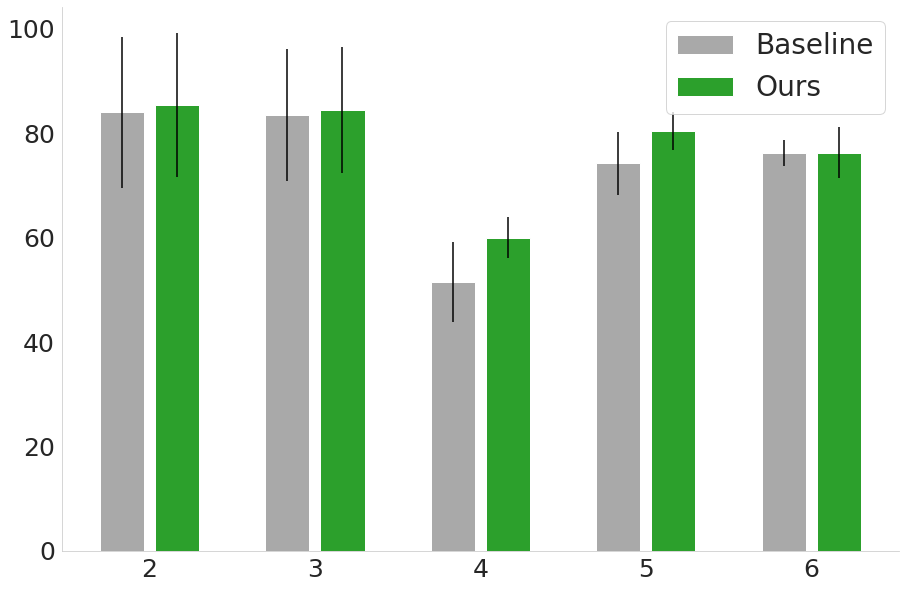

In [18]:
from collections import defaultdict


FMT_DECJ = (COL[-3], MARKER[1], '-')
COL_GREY = '#A9A9A9'


diffs = (ours - baseline)
colors = colors = [COL_GREY, FMT_DECJ[0]]
plt.figure(figsize=(15,10))
#plt.ylabel(title)
#plt.ylabel("Auccess")
for index, (data,col, name) in enumerate(zip([baseline, ours], colors, ["Baseline", "Ours"])):
    bucketed_by_moving_objects = defaultdict(lambda: [])

    for i, vals in enumerate(data):
        num_moving = moving_object_arr[i]
        bucketed_by_moving_objects[num_moving].extend(vals.tolist())


    x, y = zip(*sorted(bucketed_by_moving_objects.items()))
    y_means = [np.mean(i) * 100 for i in y]
    y_std = [np.std(i) * 100 for i in y]
    x, y = np.array(x), np.array(y)
    x_pos = np.arange(x.size) *3 + index
    plt.bar(x_pos, y_means, yerr=y_std, color=col, label=name)
    

plt.xticks(np.arange(x.size) * 3  + 0.5)
plt.gca().set_xticklabels(map(str, x))

fontsize = 25
#plt.xlabel("#Moving objects", fontsize=fontsize)
#plt.ylabel("AUCCESS", fontsize=fontsize)
plt.legend(prop={'size': 28}, loc='upper right')#, bbox_to_anchor=(0.6, 1))
plt.grid(axis="y")
plt.grid(axis="x")

ax = plt.gca()
ax.set_axisbelow(True)

tick_fontsize = 25
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 
#     tick.set_url(f'https://player.phyre.ai/#/task/:')  # Not working
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize) 
#plt.savefig("aucsByMovingObjs.pdf")
save_graph(plt.gcf(), "aucsByMovingObjs.pdf")

In [19]:
num_to_plot = 10

diffs = (ours - baseline).mean(axis=1)


ranking = diffs.argsort()
bottom = ranking[:num_to_plot//2]
top = ranking[-num_to_plot//2:]

# Bar plots with images embedded

In [20]:
%reload_ext autoreload
%autoreload 2
#from utils import *

# Color palette
# from https://medialab.github.io/iwanthue/ colorblind friendly, clustered into 6
# COL = [
#     "#ba464e",
#     "#b86b36",
#     "#a8a43f",
#     "#56ae6c",
#     "#7066bc",
#     "#b54f90"
# ]
# COL = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]  # flatui from Laurens
COL = sns.color_palette().as_hex()[:5]


MARKER = ['o', '^']
COL_BLK = 'k'
COL_GREY = '#A9A9A9'
# Formatting for different models
FMT_IN = (COL[0], MARKER[0], '-')
FMT_IN_TXCLS = (COL[0], MARKER[0], '-.')
FMT_TX = (COL[1], MARKER[0], '-')
FMT_TX_TXCLS = (COL[1], MARKER[0], '-.')
FMT_STN = (COL[-1], MARKER[1], '-')
FMT_STN_CC3D = (COL[-1], MARKER[1], '-.')
FMT_DEC = (COL[-2], MARKER[1], '-')
FMT_DEC_CC3D = (COL[-2], MARKER[1], '-.')
FMT_DECJ = (COL[-3], MARKER[1], '-')
# Upper bounds
FMT_UPPER_OPT = (COL_GREY, ',', '--')
FMT_UPPER_OBJ = (COL[0], MARKER[0], '--')
FMT_UPPER_PIX = (COL[3], MARKER[1], '--')

# Config files for the final results

CFG_WIN_GT_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/029-GT-Tx-in-class-hist1-10-v2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/031-GT-Tx-in-class-hist13.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/031-GT-Tx-in-class-hist13-nonconverged.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/029-GT-Tx-in-class-hist1-10-v2-nonconverged.txt']
CFG_WIN_GT_3F_C3D = 'expts_neurips20/060_GTSim_conv3d_allFold_wTemp_4gpu_ConvConv3D.txt'
CFG_X_GT_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/030-GT-Tx-x-class-hist1-10.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13-nonconverged2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/032-GT-Tx-x-class-hist13-nonconverged3.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/030-GT-Tx-x-class-hist1-10-nonconverged2.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results//expts_final_obj/030-GT-Tx-x-class-hist1-10-nonconverged1.txt']
CFG_X_GT_3F_C3D = ['expts_neurips20/049_GTSim_conv3d_allFold_xTemp_2gpu.txt', 'expts_neurips20/049_GTSim_conv3d_allFold_xTemp_4gpu_remaining.txt']

CFG_WIN_IN_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/006-cls-IN-win-template-final.txt/'
CFG_WIN_IN_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/037-Txcls-INfwd-withintemplate-4gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/038-Txcls-INfwd-withintemplate-8gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/041-Txcls-INfwd-withintemplate-4gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/043-Txcls-INfwd-withintemplate-8gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/049-Txcls-INfwd-withintemplate-8gpu-fwd7.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/051-Txcls-INfwd-withintemplate-8gpu-learnfair-fwd7.txt']
CFG_WIN_IN_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/000-fwd-IN-win-template-final.txt:0-9'
CFG_X_IN_3F = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/025-cls-IN-cross-template-final-fold1.txt/', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/007-cls-IN-cross-template-final-allfolds-except1.txt/']
CFG_X_IN_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/001-fwd-IN-cross-template-final.txt:0-9'

CFG_WIN_TX_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/023-cls-Tx-win-template-final.txt/'
CFG_WIN_TX_3F_TXCLS = ['/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/039-Txcls-Txfwd-withintemplate-4gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/040-Txcls-Txfwd-withintemplate-8gpu.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/042-Txcls-Txfwd-withintemplate-4gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/044-Txcls-Txfwd-withintemplate-8gpu-learnfair.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/050-Txcls-Txfwd-withintemplate-8gpu-fwd7.txt', '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/052-Txcls-Txfwd-withintemplate-8gpu-learnfair-fwd7.txt']
CFG_WIN_TX_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/018-fwd-Tx-win-template-residual-updated.txt:0-9'
CFG_X_TX_3F = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/024-cls-Tx-cross-template-final.txt/'
CFG_X_TX_3F_ROLLOUT = '/checkpoint/lgustafson/Work/FB/2019/002_Physics/phyre/results/expts_final_obj/019-fwd-Tx-cross-template-residual-updated.txt:0-9'

CFG_WIN_STN_3F = ['expts_neurips20/053_STN_cls_wtemp_from_2obInitModel_allfold_2gpu.txt', 'expts_neurips20/053_STN_cls_wtemp_from_2obInitModel_allfold_4gpu_remaining.txt']
CFG_WIN_STN_3F_CONVCONV3D = 'expts_neurips20/058_STN_cls_wtemp_from_2obInitModel_allfold_8gpu_ConvConv3D.txt'
CFG_WIN_STN_3F_ROLLOUT = 'expts_neurips20/046_STNFwd_TempAll_spatXLoss_ResNet_60str_2obj_100Kiter_lowLR_allFold.txt:0-9'
CFG_X_STN_3F = ['expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_2gpu.txt', 'expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_4gpu_remaining.txt', 'expts_neurips20/052_STN_cls_xtemp_from_2obInitModel_allfold_4gpu_remaining_fold7.txt']
CFG_X_STN_3F_ROLLOUT = 'expts_neurips20/047_STNFwd_TempAllX_spatXLoss_ResNet_60str_2obj_100Kiter_lowLR_allFold.txt:0-9'

CFG_WIN_DEC_3F = ['expts_neurips20/050_Decoder_noautoenc_10fold_2gpu.txt', 'expts_neurips20/050_Decoder_noautoenc_10fold_2gpu_remaining.txt']
CFG_WIN_DEC_3F_CONVCONV3D = 'expts_neurips20/059_Decoder_noautoenc_10fold_4gpu_ConvConv3D.txt'
CFG_WIN_DEC_3F_ROLLOUT = 'expts/358_DecoderBasedFwd_TempAllW_stride60_wtdLoss_noAutoenc_noReluLast_allFold.txt:0-9'
CFG_X_DEC_3F = ['expts_neurips20/051_Decoder_noautoenc_10fold_xtemp_2gpu.txt', 'expts_neurips20/051_Decoder_noautoenc_10fold_xtemp_2gpu_remaining.txt']
CFG_X_DEC_3F_ROLLOUT = 'expts/357_DecoderBasedFwd_TempAllX_stride60_wtdLoss_noAutoenc_noReluLast_allFold.txt:0-9'

CFG_WIN_DECJ_3F = 'expts_neurips20/045_DecoderJoint_trainFwd5Only_noReluLast_allFold.txt'
CFG_WIN_DECJ_3F_ROLLOUT = 'expts_neurips20/045_DecoderJoint_trainFwd5Only_noReluLast_allFold.txt:70-79'
CFG_X_DECJ_3F = 'expts_neurips20/044_DecoderJoint_xTemp_trainFwd5Only_noReluLast_allFold.txt'
CFG_X_DECJ_3F_ROLLOUT = 'expts_neurips20/044_DecoderJoint_xTemp_trainFwd5Only_noReluLast_allFold.txt:70-79'

## Note:
# most of the cells could be run from either phyre or phyre_laura environments. However, 
# the auccess vs object will only work in phyre_laura, and anything that needs to run the
# launch code will only work on the phyre environment
# TODO: Make everything work with the final version of phyre_laura env

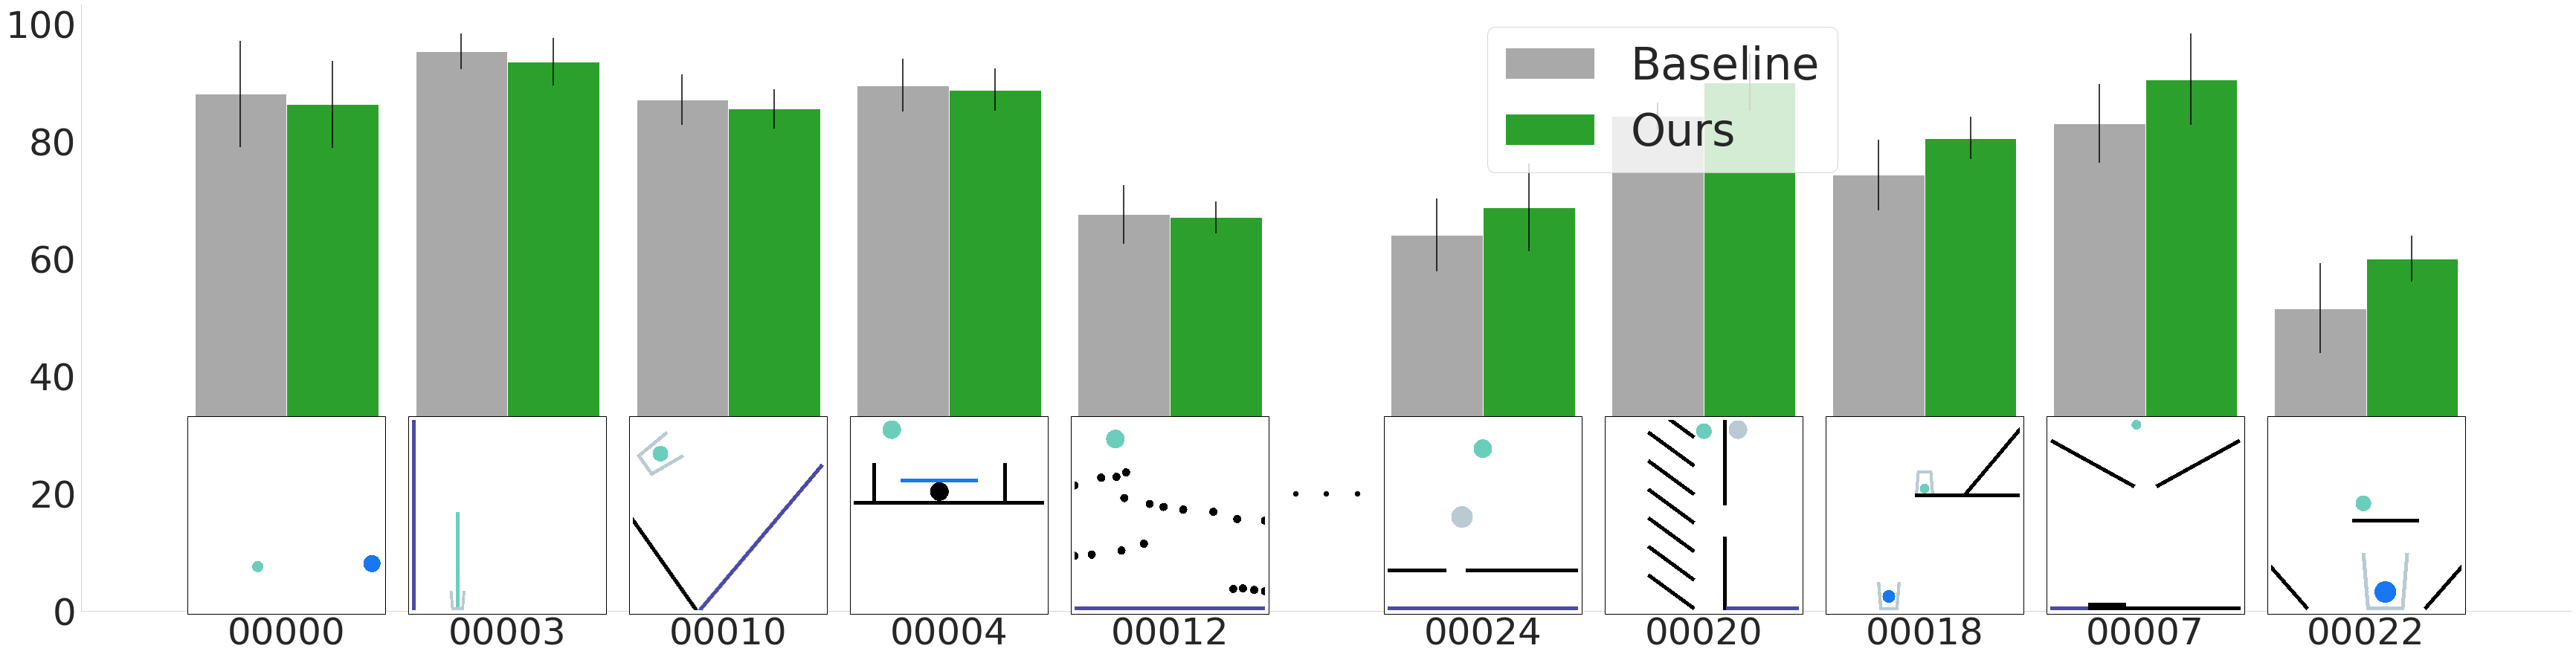

In [21]:
from matplotlib.offsetbox import (DrawingArea, OffsetImage,AnnotationBbox)
from PIL import Image
sns.set_style("whitegrid")
# The config, and the time step to use this model at
runs = [
    'expts_neurips20/026_DecoderJoint_1f_5fwdOnly_noReluLast_allFold.txt:train.n_fwd_times=0',
    'expts_neurips20/026_DecoderJoint_1f_5fwdOnly_noReluLast_allFold.txt:train.n_fwd_times=10',
]
run_names = [
    'Dec [Joint] 1f (τ\'=0)', 'Dec [Joint] 1f (τ\'=10)',
]
colors = [COL_GREY, FMT_DECJ[0]]
assert len(run_names) == len(runs)

#results = [read_results_by_template(run) for run in runs]
#temp_names = list(results[0].keys())

ntemp_to_keep = 5  # 5 on both sides
bar_width = 2.0 / ntemp_to_keep  # set width of bar
offset = bar_width * len(runs) * 1.2  # Gap between bars
left_right_gap = bar_width  # Gap between the first 5 and last 5

run_all_temp_aucs = []
# for result in results:
#     # It returns all the AUCCESS per task (for all folds), so sum that into a list
#     temp_aucs = [sum(result[temp].values(), []) for temp in temp_names]
#     # Convert into a mean and variance, ignoring NaNs.. since those are the cases when
#     # that task didn't occur in the test set
#     temp_aucs = np.array([(np.nanmean(el), np.nanstd(el)) for el in temp_aucs])
#     run_all_temp_aucs.append(temp_aucs)

#order = np.argsort([run_all_temp_aucs[-1][i][0] - run_all_temp_aucs[0][i][0] for i in range(len(temp_names))])


#order_to_show = np.concatenate((order[:5], order[-5:]))  # show only the first and last 5 for space
diffs = (ours - baseline).mean(axis=1)
order_to_show = np.argsort(diffs)
order_to_show = np.concatenate([order_to_show[:ntemp_to_keep], order_to_show[-ntemp_to_keep:]])
sorted_templates = np.arange(diffs.size * 2)[order_to_show]

ours_to_plot = ours[order_to_show]
baseline_to_plot = baseline[order_to_show]


pos = np.arange(len(order_to_show))
xticks_pos = pos * offset  # pos of the first bar
xticks_pos[ntemp_to_keep:] += left_right_gap
xticks_pos_mid = xticks_pos + bar_width / 2.0  # pos of the midpoint of all bars
fig = plt.figure(figsize=(60, 15))

for i, (name, result, col) in enumerate(zip(["Baseline", "Ours"], [baseline_to_plot, ours_to_plot], colors)):
    means = result.mean(axis=1)[:10] * 100
    errs = result.std(axis=1)[:10] * 100
    bar = plt.bar(
        xticks_pos + i * bar_width,
        means,
        yerr=errs,
        width=bar_width, edgecolor='white',
        color=col,
        label=name)
    
# Plot some dots in the gap
NDOTS = 3
gap_center = 0.5 * (xticks_pos[ntemp_to_keep-1] + xticks_pos[ntemp_to_keep] + bar_width)
ax = plt.gca()
for i in range(NDOTS):
    ax.scatter(gap_center + (bar_width / NDOTS) * (i - NDOTS // 2), 20, color='k', s=40)
    
# Add xticks, and small images
# Based on https://stackoverflow.com/a/52426377
# Get the simulator for images
# Just using within template to get some task corresponding to each template
eval_setup_name = 'ball_within_template'
# Using fold 0 to get any task corresponding to the template, for vis

# plt.ylim(0.2, 1.2)

ax = plt.gca()
nobjs_in_order = []
for i, template_no in enumerate(sorted_templates):
#     this_temp = temp_names[order_i]
#     task_id_of_this_temp = [i for i, el in enumerate(eval_task_ids) if el.startswith(this_temp)]
#     # Use all tasks to get avg number of objects for this template
#     this_temp_nobj = [simulator.initial_featurized_objects[t].num_objects
#                       for t in task_id_of_this_temp]
#     try:
#         this_temp_nobj = [simulator.initial_featurized_objects[t].num_objects
#                           for t in task_id_of_this_temp]
#         this_temp_nobj = (np.mean(this_temp_nobj), np.std(this_temp_nobj))
#     except:
#         this_temp_nobj = (float('nan'), float('nan'))
#     nobjs_in_order.append(this_temp_nobj)
    

    # Else, show the small image of the template
    # Get image from any task of this template
    arr_img = one_per_template_sim.initial_scenes[template_no]
    img = Image.fromarray(phyre.vis.observations_to_uint8_rgb(arr_img))
    # img.putalpha(int(0.5 * 255))  # somehow this is not working
    # Making this smaller made it really pixelated
    imagebox = OffsetImage(img, zoom=1.0, interpolation='bilinear')
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,
                        (xticks_pos_mid[i], 0.01),
                        xybox=(0, -7),
                        xycoords=('data', 'axes fraction'),
                        boxcoords='offset points',
                        box_alignment=(0.5, 0),
                        pad=0.5,
                        bboxprops={'edgecolor' : 'black'})
    ax.add_artist(ab)

nobjs_in_order = np.array(nobjs_in_order)
# If we were able to get obj counts, make a graph
plot_obj_line = False
if not np.any(np.isnan(nobjs_in_order)) and plot_obj_line:
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(xticks_pos, nobjs_in_order, color='green',
             linewidth=20, alpha=0.3)
    ax2.set_yscale('log')
    ax2.set_ylabel('Number of objects')
    ax2.tick_params(axis='y', labelcolor='green')
plt.xticks(xticks_pos_mid, map(lambda x:"%05d" %x, sorted_templates))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(50) 
#     tick.set_url(f'https://player.phyre.ai/#/task/:')  # Not working
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(50) 
ax.legend(prop={'size': 60}, loc='upper center', bbox_to_anchor=(0.635, 1))
#ax.set_ylabel('AUCCESS', fontsize=80)
ax.grid(axis='x')
ax.grid(axis='y')
ax.set_axisbelow(True)
#plt.savefig("aucsByTemplate.pdf")
save_graph(plt.gcf(), "aucsByTemplate.pdf")

In [53]:
!python -m http.server 30303


Serving HTTP on 0.0.0.0 port 30303 (http://0.0.0.0:30303/) ...
127.0.0.1 - - [06/Oct/2020 15:12:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2020 15:12:58] "GET /aucsByMovingObjs.png HTTP/1.1" 200 -
^C

Keyboard interrupt received, exiting.


In [222]:
order_to_show

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [230]:
ours

array([[0.94, 0.91, 0.89, 0.94],
       [0.97, 1.  , 0.97, 0.95],
       [1.  , 1.  , 1.  , 1.  ],
       [0.96, 0.96, 0.97, 0.97],
       [0.9 , 0.95, 0.89, 0.93],
       [0.95, 0.99, 0.98, 0.97],
       [0.93, 0.91, 0.9 , 0.85],
       [0.92, 0.83, 0.68, 0.8 ],
       [0.96, 0.95, 0.84, 1.  ],
       [0.84, 0.85, 0.88, 0.82],
       [0.88, 0.85, 0.88, 0.9 ],
       [0.54, 0.52, 0.59, 0.54],
       [0.72, 0.77, 0.78, 0.64],
       [0.63, 0.62, 0.74, 0.62],
       [0.78, 0.75, 0.78, 0.75],
       [1.  , 0.93, 0.95, 0.97],
       [0.77, 0.83, 0.82, 0.78],
       [0.77, 0.85, 0.91, 0.83],
       [0.75, 0.72, 0.64, 0.69],
       [0.47, 0.67, 0.65, 0.58],
       [0.97, 0.98, 0.94, 0.95],
       [0.93, 0.93, 0.94, 0.94],
       [0.71, 0.61, 0.69, 0.68],
       [0.72, 0.72, 0.84, 0.79],
       [0.66, 0.7 , 0.72, 0.68]])

In [231]:
baseline

array([[0.96, 0.94, 0.93, 0.93],
       [0.98, 0.99, 0.98, 1.  ],
       [1.  , 1.  , 0.99, 1.  ],
       [0.97, 0.96, 1.  , 0.97],
       [0.89, 0.86, 0.89, 0.9 ],
       [0.98, 1.  , 0.99, 0.98],
       [0.88, 0.94, 0.81, 0.84],
       [0.85, 0.76, 0.66, 0.67],
       [0.92, 0.85, 0.87, 0.98],
       [0.88, 0.87, 0.87, 0.87],
       [0.85, 0.88, 0.85, 0.82],
       [0.55, 0.41, 0.47, 0.42],
       [0.66, 0.74, 0.76, 0.68],
       [0.59, 0.65, 0.62, 0.7 ],
       [0.67, 0.71, 0.76, 0.68],
       [0.95, 0.92, 0.91, 0.94],
       [0.88, 0.82, 0.85, 0.74],
       [0.77, 0.87, 0.82, 0.9 ],
       [0.7 , 0.67, 0.67, 0.69],
       [0.52, 0.58, 0.64, 0.58],
       [0.84, 0.87, 0.9 , 0.92],
       [0.91, 0.93, 0.92, 0.94],
       [0.65, 0.54, 0.62, 0.67],
       [0.71, 0.78, 0.8 , 0.77],
       [0.62, 0.63, 0.66, 0.56]])

In [23]:
ours

array([[0.94, 0.91, 0.89, 0.94],
       [0.97, 1.  , 0.97, 0.95],
       [1.  , 1.  , 1.  , 1.  ],
       [0.96, 0.96, 0.97, 0.97],
       [0.9 , 0.95, 0.89, 0.93],
       [0.95, 0.99, 0.98, 0.97],
       [0.93, 0.91, 0.9 , 0.85],
       [0.92, 0.83, 0.68, 0.8 ],
       [0.96, 0.95, 0.84, 1.  ],
       [0.84, 0.85, 0.88, 0.82],
       [0.88, 0.85, 0.88, 0.9 ],
       [0.54, 0.52, 0.59, 0.54],
       [0.72, 0.77, 0.78, 0.64],
       [0.63, 0.62, 0.74, 0.62],
       [0.78, 0.75, 0.78, 0.75],
       [1.  , 0.93, 0.95, 0.97],
       [0.77, 0.83, 0.82, 0.78],
       [0.77, 0.85, 0.91, 0.83],
       [0.75, 0.72, 0.64, 0.69],
       [0.47, 0.67, 0.65, 0.58],
       [0.97, 0.98, 0.94, 0.95],
       [0.93, 0.93, 0.94, 0.94],
       [0.71, 0.61, 0.69, 0.68],
       [0.72, 0.72, 0.84, 0.79],
       [0.66, 0.7 , 0.72, 0.68]])